# Style Transfer

Using the trained Auto-Encoder to make Style Transfer.

Take as input an:
+ **image**
+ **art style** (style embedding)

Their combination will then *yield* a unique newly generated image.

## Main Code

### Preliminaries

In [1]:
# Any installs
! pip install cowsay 

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Declare Imports
import os, sys, json
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
# Create some relevant folders for data persistence
sys.path.append('..')

In [3]:
# CONFIGURATIONS
trainingdir = "/scratch/lt2326-2926-h24/wikiart/train"
testingdir = "/scratch/lt2326-2926-h24/wikiart/train"
device = "cuda:0"

BATCHED = True

In [4]:
# Reload modules (uncomment when actively editing an imported module 
# w.o. needing to restart kernel)
from importlib import reload
import wikiart
reload(wikiart)
from wikiart import WikiArtDataset

# LOAD DATASET
traindataset = WikiArtDataset(trainingdir, device)

Gathering files for /scratch/lt2326-2926-h24/wikiart/train
...............................finished


In [59]:
import torch
# Data Loading Time
weights = traindataset.get_balancing_weights()
weights[2400]


weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     

train_loader_balanced = torch.utils.data.DataLoader(
    traindataset, 
    batch_size = 32,
    sampler = sampler, 
    drop_last = True,
) 

{'New_Realism': 0, 'Pop_Art': 0, 'High_Renaissance': 0, 'Minimalism': 0, 'Ukiyo_e': 0, 'Northern_Renaissance': 0, 'Realism': 0, 'Art_Nouveau_Modern': 0, 'Fauvism': 0, 'Post_Impressionism': 0, 'Baroque': 0, 'Contemporary_Realism': 0, 'Mannerism_Late_Renaissance': 0, 'Abstract_Expressionism': 0, 'Analytical_Cubism': 0, 'Naive_Art_Primitivism': 0, 'Color_Field_Painting': 0, 'Pointillism': 0, 'Symbolism': 0, 'Synthetic_Cubism': 0, 'Action_painting': 0, 'Expressionism': 0, 'Rococo': 0, 'Early_Renaissance': 0, 'Romanticism': 0, 'Impressionism': 0, 'Cubism': 0}
{'New_Realism': 41, 'Pop_Art': 244, 'High_Renaissance': 198, 'Minimalism': 212, 'Ukiyo_e': 197, 'Northern_Renaissance': 413, 'Realism': 1712, 'Art_Nouveau_Modern': 688, 'Fauvism': 163, 'Post_Impressionism': 946, 'Baroque': 721, 'Contemporary_Realism': 91, 'Mannerism_Late_Renaissance': 246, 'Abstract_Expressionism': 449, 'Analytical_Cubism': 15, 'Naive_Art_Primitivism': 373, 'Color_Field_Painting': 268, 'Pointillism': 80, 'Symbolism': 6

In [117]:
# Clear GPU cache and garbage collector stuff
import gc
gc.collect()
torch.cuda.empty_cache()

### Learning Style Embeddings

In [61]:
# We train a simple discriminator to obtain style embeddings.

In [62]:
from torch import nn
import pdb

# Embeddings module
class StyleEmbeddings(nn.Module):
    def __init__(self, n_style, d_style):
        super(StyleEmbeddings, self).__init__()
        self.embds = nn.Embedding(n_style, d_style)

    def forward(self, x):
        return self.embds(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # self.gpu=gpu
        self.n_classes = n_classes
        self.embds = StyleEmbeddings(n_classes, 32)
        self.fc1 = nn.Linear(n_classes, n_classes)
        self.softmax = nn.Softmax(dim=1)
    
    # def getGpu(self):
    #     return self.gpu

    def forward(self, input):
        out = self.fc1(input)
        out = self.softmax(out)

        # out = F.log_softmax(out, dim=1)
        return out  # batch_size * label_size

    def getFc(self, input):
        return self.fc1(input)

    def getSig(self, input):
        return self.softmax(input)
    
    def getSim(self, latent, style=None):
        #latent_norm=torch.norm(latent, dim=-1) #batch, dim
        # Clone, because we don't want the update to happen in latent space
        latent_clone=latent.clone()
        # if style is not None:
        #     style=style.unsqueeze(2)
        #     style=self.style_embed(style.long())
        #     # pdb.set_trace()
        #     style=style.reshape(style.size(0), style.size(1), style.size(-1))
        # else:
        style=torch.tensor([[[i] for i in range(self.n_classes)]]).long().to(device)
        style=torch.cat(latent.size(0)*[style]) #128, 2, 1
        style=style.reshape(latent_clone.size(0), -1, 1)
        # get the according style embedding for each sample in batch
        style=self.embds(style) #(batch. style_num, 1, dim)
        style=style.reshape(style.size(0), style.size(1), -1)
        # Binary measure: Does input correspond to style?
        # 1 => yes, 0 => no depending on cosine similarity
        # Use torch.bmm between style embeddings
        # and encoder embeddings.
        dot=torch.bmm(style, latent_clone.unsqueeze(2)) #batch, style_num, 1
        dot=dot.reshape(dot.size(0), dot.size(1))
        return style, dot


### Style-Augmented AutoEncoder

In [63]:
# The model takes the image itself in conjunction
# with a style embedding.


# Then it again learns to reconstruct the original image.
import torch.nn as nn

class Flatten(torch.nn.Module):
    def forward(self, x):
        # print("Test, test, test")
        # batch_size = x.shape[0] * x.shape[1] * x.shape[2]
        # print("Shapes", x.shape[0], x.shape[1], x.shape[2])
        # ret = x.view(batch_size, 1)
        ret = x.view(x.size(0), -1)
        # print("Ret shape", ret.shape)
        return ret

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3 , 3*3, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(9,16,kernel_size=5),
            nn.ReLU(True),
            Flatten(),
            nn.Linear(16 * 408 * 408, 32)
            )
        self.decoder = nn.Sequential( 
            nn.Linear(32, 16 * 408 * 408),
            nn.Unflatten(1, [16, 408, 408]),
            nn.ConvTranspose2d(16,9,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(9,3,kernel_size=5),
            nn.ReLU(True))
    def forward(self, x):
        x = self.encoder(x)
        # print("Encoding success!")
        x = self.decoder(x)
        return x

In [64]:
from torch.optim import lr_scheduler

LEARNING_RATE = 0.1

# Training the style embeddings
# We use BCELoss as criterion.
discriminator = Discriminator(len(traindataset.classes)).to(device)
dis_criterion=torch.nn.CrossEntropyLoss()
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

autoencoder = AutoEncoder().to(device)
loss_ = nn.MSELoss()
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

# Use learning rate decay - reduce learning rate as training continues
scheduler = lr_scheduler.StepLR(optimizer_ae, 
                                  step_size=100,
                                  gamma=0.1)

In [65]:
traindataset.classes

['New_Realism',
 'Pop_Art',
 'High_Renaissance',
 'Minimalism',
 'Ukiyo_e',
 'Northern_Renaissance',
 'Realism',
 'Art_Nouveau_Modern',
 'Fauvism',
 'Post_Impressionism',
 'Baroque',
 'Contemporary_Realism',
 'Mannerism_Late_Renaissance',
 'Abstract_Expressionism',
 'Analytical_Cubism',
 'Naive_Art_Primitivism',
 'Color_Field_Painting',
 'Pointillism',
 'Symbolism',
 'Synthetic_Cubism',
 'Action_painting',
 'Expressionism',
 'Rococo',
 'Early_Renaissance',
 'Romanticism',
 'Impressionism',
 'Cubism']

In [66]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# Then pass it simple into a classifier and backprop.

autoencoder_losses = []
discriminator_losses = []
discriminator_acc = []

n_epochs = 5
eval_every = 10
# best_loss = np.infty

with tqdm(total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        for batch in tqdm(train_loader_balanced):
            ### LABELS ###
            lbls = batch[1]
            lbls_unsq = lbls.unsqueeze(1)
            y_onehot = torch.FloatTensor(32, discriminator.n_classes)
            # In your for loop
            y_onehot.zero_()
            y_onehot = y_onehot.float()
            y_onehot.scatter_(1, lbls_unsq, 1)

            ### GET ENCODED INPUTS ###
            inputs = batch[0].to(device)
            encoded = autoencoder.encoder(inputs)
            # encoded = encoded.cpu().detach() # these must not be updated

            ### GET SIMILARITY ###
            style, similarity=discriminator.getSim(encoded) #style (128, 2, 256), sim(128, 2)
            dis_out=discriminator.forward(similarity)
            # one=torch.tensor(1)
            # zero=torch.tensor(0)
            # style_pred=torch.where(dis_out>0.5, one, zero)
            max_idx = torch.argmax(dis_out, 1, keepdim=True)
            # max_idx = max_idx.squeeze(0).unsqueeze(1)
            one_hot = torch.FloatTensor(dis_out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(1, max_idx, 1)
            # style_pred=style_pred.reshape(one_hot.size(0))
            style_pred = one_hot
            style_emb=style.clone()[torch.arange(style.size(0)), lbls.squeeze().long()] #(128, 256)
            style_loss=dis_criterion(dis_out.to(device), y_onehot.to(device))


            ### STYLE-AUGMENTED AUTOENCOER FORWARD PASS ###
            add_latent=encoded+style_emb #batch, dim
            out=autoencoder.decoder(add_latent)
            loss_rec=loss_(out, inputs)

            ### COMBINED LOSS AND BACKPROPAGATION
            pred=style_pred.to('cpu').detach()
            pred = torch.argmax(pred, dim=1).tolist()
            true=lbls.squeeze().to('cpu').tolist()

            # import pdb; pdb.set_trace()
            dis_acc=accuracy_score(pred, true)
            discriminator_acc.append(dis_acc)
            loss=loss_rec+style_loss
            
            optimizer_ae.zero_grad()
            optimizer_dis.zero_grad()
            loss.backward()
            optimizer_ae.step()
            optimizer_dis.step()

            autoencoder_losses.append(loss_rec.item())
            discriminator_losses.append(style_loss.item())



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Experiments with different styles

In [67]:
# List of possible artstyles
traindataset.classes

['New_Realism',
 'Pop_Art',
 'High_Renaissance',
 'Minimalism',
 'Ukiyo_e',
 'Northern_Renaissance',
 'Realism',
 'Art_Nouveau_Modern',
 'Fauvism',
 'Post_Impressionism',
 'Baroque',
 'Contemporary_Realism',
 'Mannerism_Late_Renaissance',
 'Abstract_Expressionism',
 'Analytical_Cubism',
 'Naive_Art_Primitivism',
 'Color_Field_Painting',
 'Pointillism',
 'Symbolism',
 'Synthetic_Cubism',
 'Action_painting',
 'Expressionism',
 'Rococo',
 'Early_Renaissance',
 'Romanticism',
 'Impressionism',
 'Cubism']

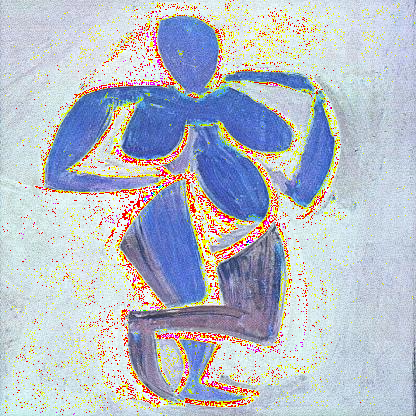

In [122]:
import torchvision
import torchvision.transforms as T
from PIL import Image

IMAGE_NO = 350

# Select image
image = traindataset[IMAGE_NO][0]

# Select an image
transform = T.ToPILImage()
img = transform(image)
display(img)

In [123]:
discriminator.embds.embds.weight.data.shape
style_embeddings = discriminator.embds.embds.weight.data

In [124]:
image

tensor([[[ 57.,  72.,  51.,  ...,  66.,  90., 113.],
         [ 63.,  94.,  79.,  ...,  70.,  92., 120.],
         [ 79.,  75.,  71.,  ...,  51.,  94., 144.],
         ...,
         [ 62., 103.,  45.,  ...,  95., 107., 190.],
         [ 78.,  75.,  87.,  ..., 126., 127., 194.],
         [ 81.,  63.,  66.,  ..., 133., 134., 187.]],

        [[ 47.,  62.,  41.,  ...,  57.,  81., 104.],
         [ 53.,  84.,  69.,  ...,  61.,  83., 111.],
         [ 69.,  65.,  61.,  ...,  44.,  87., 137.],
         ...,
         [ 24.,  65.,  10.,  ...,  81.,  95., 178.],
         [ 40.,  37.,  52.,  ..., 112., 115., 182.],
         [ 43.,  25.,  31.,  ..., 119., 122., 175.]],

        [[ 37.,  52.,  31.,  ...,  28.,  52.,  75.],
         [ 43.,  74.,  59.,  ...,  32.,  54.,  82.],
         [ 59.,  55.,  51.,  ...,  16.,  58., 108.],
         ...,
         [ 21.,  62.,   6.,  ...,  68.,  81., 164.],
         [ 37.,  34.,  48.,  ..., 101., 103., 170.],
         [ 40.,  22.,  27.,  ..., 108., 110., 163.]]]

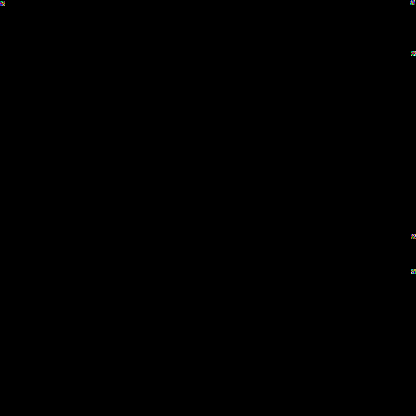

In [135]:
# Get the style embeddings

def style_augmented_image(image, original_style, artstyle):
    idx_new = traindataset.classes.index(artstyle)
    idx_original = traindataset.classes.index(original_style)
    # import pdb; pdb.set_trace()
    # inputs, classes = next(iter(train_loader_balanced))  
    inputs = image.unsqueeze(0) 
    encoded_repr = autoencoder.encoder(inputs)
    mod_enc_repr = encoded_repr - style_embeddings[idx_original] + style_embeddings[idx_new]
    return autoencoder.decoder(mod_enc_repr)

display(transform(style_augmented_image(
    image,
    traindataset.classes[traindataset[IMAGE_NO][1]],
    "Pop_Art"
).squeeze()))

In [ ]:
# More code using the function 

## Any final remarks
- Either in MD or in code (like below)